In [25]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn.metrics import multilabel_confusion_matrix, classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

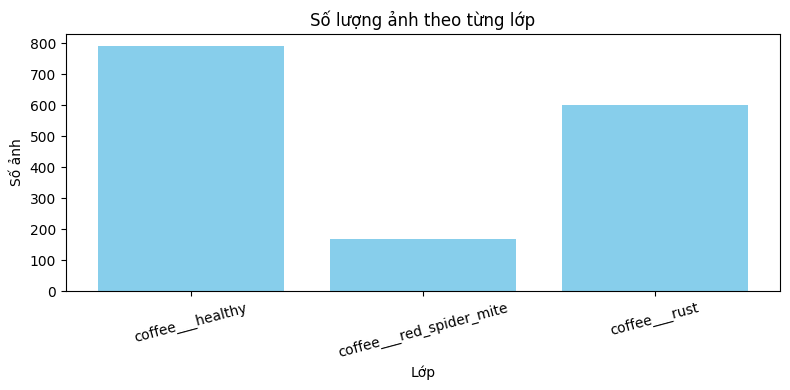

In [26]:
#. Trực quan hóa dữ liệu ban đầu
DATA_DIR = r'D:\Thư mục mới\coffe_data'
# Đếm số ảnh trong mỗi lớp
class_counts = collections.Counter()
for cls in os.listdir(DATA_DIR):
    cls_path = os.path.join(DATA_DIR, cls)
    if os.path.isdir(cls_path):
        num_images = len([f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))])
        class_counts[cls] = num_images

# Vẽ biểu đồ số lượng ảnh theo lớp
plt.figure(figsize=(8, 4))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Số lượng ảnh theo từng lớp')
plt.xlabel('Lớp')
plt.ylabel('Số ảnh')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [27]:
#Tạo ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 1249 images belonging to 3 classes.
Found 311 images belonging to 3 classes.


In [28]:
# 4. Xây dựng mô hình với MobileNetV2
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [29]:
# 5. Huấn luyện mô hình
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]
history = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=callbacks)

c:\ProgramData\miniconda3\envs\r_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.4603 - loss: 1.1884 - val_accuracy: 0.6109 - val_loss: 0.8636 - learning_rate: 0.0010
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.6060 - loss: 0.9411 - val_accuracy: 0.7074 - val_loss: 0.7017 - learning_rate: 0.0010
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.6620 - loss: 0.8129 - val_accuracy: 0.6977 - val_loss: 0.7110 - learning_rate: 0.0010
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.6549 - loss: 0.8018 - val_accuracy: 0.6720 - val_loss: 0.7626 - learning_rate: 0.0010
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.6936 - loss: 0.7487 - val_accuracy: 0.7299 - val_loss: 0.6244 - learning_rate: 2.0000e-04
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7153 - loss: 0.6765 - val_accuracy: 0.7170 - val_loss: 0.6660 - learning_rate: 2.0000e-04
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7162 - loss: 0.6879 - val_ac

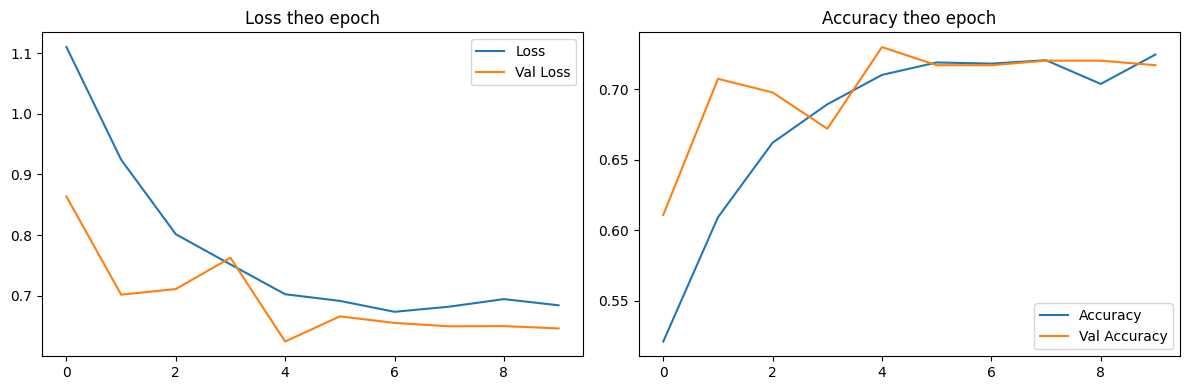

In [30]:
# 6. Vẽ biểu đồ training
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss theo epoch')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy theo epoch')
plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


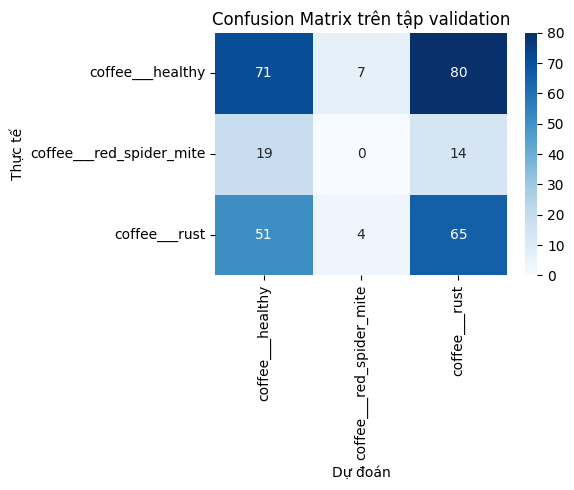

In [31]:
# Vẽ confusion matrix sau khi fine-tune
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Dự đoán tập validation
val_preds = model.predict(val_gen)
y_true = val_gen.classes
y_pred = np.argmax(val_preds, axis=1)

# Lấy label names
class_names = list(train_gen.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Confusion Matrix trên tập validation')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


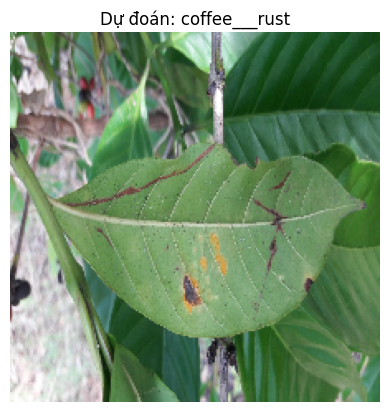

In [32]:
# 8. Thử nghiệm mô hình với ảnh từ dataset
from tensorflow.keras.preprocessing import image
import numpy as np

# Lấy ảnh bất kỳ từ validation set
import random
sample_class = random.choice(os.listdir(DATA_DIR))
sample_folder = os.path.join(DATA_DIR, sample_class)
sample_img = random.choice(os.listdir(sample_folder))
sample_path = os.path.join(sample_folder, sample_img)

# Tiền xử lý ảnh
img = image.load_img(sample_path, target_size=(IMG_SIZE, IMG_SIZE))
x = image.img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)

# Dự đoán
pred = model.predict(x)
class_names = list(train_gen.class_indices.keys())
predicted_label = class_names[np.argmax(pred)]

# Hiển thị ảnh và kết quả
plt.imshow(img)
plt.axis('off')
plt.title(f'Dự đoán: {predicted_label}')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


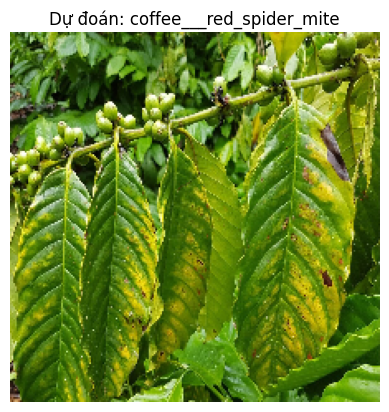

In [35]:
IMG_SIZE = (224, 224)
# Nhập đường dẫn hình ảnh
uploaded_path = "C:/Users/Admin/Downloads/cf.jpg"
uploaded_path = os.path.normpath(uploaded_path)

# Tải và tiền xử lý hình ảnh
try:
    img = image.load_img(uploaded_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)

    # Dự đoán
    pred = model.predict(x)
    class_names = list(train_gen.class_indices.keys())
    predicted_label = class_names[np.argmax(pred)]

    # Hiển thị hình ảnh và kết quả dự đoán
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Dự đoán: {predicted_label}')
    plt.show()

except FileNotFoundError as e:
    print(f"Lỗi: Tệp không tồn tại tại {uploaded_path}. Vui lòng kiểm tra đường dẫn.")
except PermissionError as e:
    print(f"Lỗi quyền truy cập: {e}. Vui lòng kiểm tra quyền hoặc đóng ứng dụng đang sử dụng tệp.")
except Exception as e:
    print(f"Lỗi không xác định: {e}")